In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/My Drive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


## Import Libraries


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import pycountry_convert as pyc
import plotly.express as px
import plotly.graph_objects as go

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Exploration

In [ ]:
df = pd.read_csv('hotel-data.csv')
print('Dimnesions of data:', df.shape)

Dimnesions of data: (16151, 9)


In [ ]:
print('Top 5 rows of data:')
df.head()

Top 5 rows of data:


,index,check_in_date,check_out_date,booking_date,Country,room_type_code,Status,stay_duration,price_pernight
0,1,2013-07-24,2013-07-25,2013-06-06T14:24:10Z,Netherlands,D1,Checked Out,1,30.00
1,2,NaN,NaN,2013-06-07T00:09:08Z,Denmark,D1,Cancelled,0,28.99
2,3,2013-08-01,2013-08-03,2013-06-07T00:09:20Z,Switzerland,D2,Checked Out,2,25.38
3,4,2013-08-01,2013-08-03,2013-06-07T00:09:20Z,Switzerland,D2,Checked Out,2,29.60
4,5,2013-07-26,2013-07-27,2013-06-07T00:09:42Z,NaN,D3,Checked Out,1,29.90


In [ ]:
print('Basic statistical information:')
df.describe(include='all')

Basic statistical information:


,index,check_in_date,check_out_date,booking_date,Country,room_type_code,Status,stay_duration,price_pernight
count,16151.000000,15184,15184,16151,14515,16151,16151,16151.000000,16151.000000
unique,NaN,600,600,15750,115,12,2,NaN,NaN
top,NaN,2014-04-19,2013-11-03,2014-04-06T03:05:48Z,China,D2,Checked Out,NaN,NaN
freq,NaN,49,49,3,1889,2553,15184,NaN,NaN
mean,8076.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.717417,30.378639
std,4662.536434,NaN,NaN,NaN,NaN,NaN,NaN,1.653148,9.284689
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,20.520000
25%,4038.500000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,25.000000
50%,8076.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,26.990000
75%,12113.500000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,30.990000


In [ ]:
print('Data types of all columns:')
print(df.dtypes)

Data types of all columns:
index               int64
check_in_date      object
check_out_date     object
booking_date       object
Country            object
room_type_code     object
Status             object
stay_duration       int64
price_pernight    float64
dtype: object


In [ ]:
print('Number of missing values in each column:')
print(df.isnull().sum())

Number of missing values in each column:
index                0
check_in_date      967
check_out_date     967
booking_date         0
Country           1636
room_type_code       0
Status               0
stay_duration        0
price_pernight       0
dtype: int64


***
## Data Cleaning

In [ ]:
def pre_proccessing(df):
  # remove index column
  df.drop('index', axis=1, inplace=True)
  
  # replace empty missing country names with 'unknown'
  df['Country'].replace(np.nan, 'Unknown', inplace=True)

  # convert check_in_date column into datetime format
  df['check_in_date'] = pd.to_datetime(df['check_in_date'])
  # convert check_out_date column into datetime format
  df['check_out_date'] = pd.to_datetime(df['check_out_date'])  
  # convert booking_date column into datetime format
  df['booking_date'] = pd.to_datetime(df['booking_date'])
  
  # add columns for month 
  df['check_in_month'] = df['check_in_date'].dt.month
  df['check_out_month'] = df['check_out_date'].dt.month
  df['book_month'] = df['booking_date'].dt.month

  # add columns for days 
  df['check_in_day'] = df['check_in_date'].dt.day
  df['check_out_day'] = df['check_out_date'].dt.day
  df['book_day'] = df['booking_date'].dt.day
  
  # add column for weekdays
  df['check_in_weekday'] = df['check_in_date'].dt.dayofweek
  df['check_out_weekday'] = df['check_out_date'].dt.dayofweek
  df['book_weekday'] = df['booking_date'].dt.dayofweek

  # add column for time of booking
  df['book_date'] = pd.to_datetime([d.date() for d in df['booking_date']])
  df['book_time'] = [d.time() for d in df['booking_date']]

  # make sure that missing values for check_in_date are because of cancelled rooms
  print('Number of missing check_in_date:',
        df.check_in_date.isnull().sum())
  print('Number of missing check_in_date and cancelled rooms:',
        df[(df['Status'] == 'Cancelled') & (df['check_in_date'].isnull())].shape[0])

  # calculate total_price based on stay_duration and price_per_night
  df['total_price'] = df['stay_duration'] * df['price_pernight']

  # make sure that stay_duration is equal to difference between check_in and check_out dates
  df_check_delta = (df['check_out_date'] - df['check_in_date']).dt.days
  df['stay_duration'].astype(float)
  df_diff = np.where((( df['stay_duration'] != df_check_delta) & df['stay_duration'] != 0), True, False)
  print('Number of rows with different time_delta and stay_duration',
        df[df_diff == True].shape[0])

  # add column for days between check_in_date and book_date
  df['book_check_diff'] = (df['check_in_date'] - df['book_date'])

  # add country name abbreviation column for further use in visualization
  countries = {}
  for country in pycountry.countries:
    countries[country.name] = country.alpha_2
  df['country_code'] = [countries.get(country, 'Unknown') for country in df['Country']]

  # Print some statistical info
  print('First check-in date:', df.check_in_date.min())
  print('Last check-out date: ', df.check_out_date.max())

  return df

In [ ]:
df = pre_proccessing(df)
df.head()

Number of missing check_in_date: 967
Number of missing check_in_date and cancelled rooms: 967
Number of rows with different time_delta and stay_duration 0
First check-in date: 2013-07-01 00:00:00
Last check-out date:  2015-02-21 00:00:00


,check_in_date,check_out_date,booking_date,Country,room_type_code,Status,stay_duration,price_pernight,check_in_month,check_out_month,book_month,check_in_day,check_out_day,book_day,check_in_weekday,check_out_weekday,book_weekday,book_date,book_time,total_price,book_check_diff,country_code
0,2013-07-24,2013-07-25,2013-06-06 14:24:10+00:00,Netherlands,D1,Checked Out,1,30.00,7.0,7.0,6,24.0,25.0,6,2.0,3.0,3,2013-06-06,14:24:10,30.00,48 days,NL
1,NaT,NaT,2013-06-07 00:09:08+00:00,Denmark,D1,Cancelled,0,28.99,NaN,NaN,6,NaN,NaN,7,NaN,NaN,4,2013-06-07,00:09:08,0.00,NaT,DK
2,2013-08-01,2013-08-03,2013-06-07 00:09:20+00:00,Switzerland,D2,Checked Out,2,25.38,8.0,8.0,6,1.0,3.0,7,3.0,5.0,4,2013-06-07,00:09:20,50.76,55 days,CH
3,2013-08-01,2013-08-03,2013-06-07 00:09:20+00:00,Switzerland,D2,Checked Out,2,29.60,8.0,8.0,6,1.0,3.0,7,3.0,5.0,4,2013-06-07,00:09:20,59.20,55 days,CH
4,2013-07-26,2013-07-27,2013-06-07 00:09:42+00:00,Unknown,D3,Checked Out,1,29.90,7.0,7.0,6,26.0,27.0,7,4.0,5.0,4,2013-06-07,00:09:42,29.90,49 days,Unknown


***
## Data Visualization

Text(0.5, 1.0, 'Distribution of price pernight for each room type')

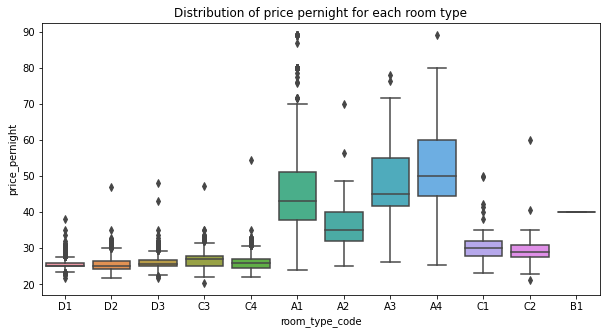

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(x='room_type_code', 
            y='price_pernight', 
            data=df,
            ax=ax)

ax.set_title('Distribution of price pernight for each room type')

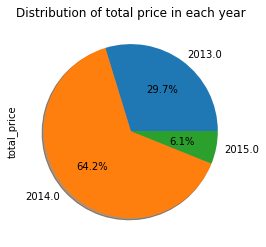

In [ ]:
df_date_price = df[['check_out_date', 'total_price']]
df_year = df_date_price.groupby([df['check_out_date'].dt.year]).sum()

df_year.plot(kind='pie', 
             y ='total_price', 
             autopct='%1.1f%%', 
             shadow=True, 
             legend = False, 
             title='Distribution of total price in each year')

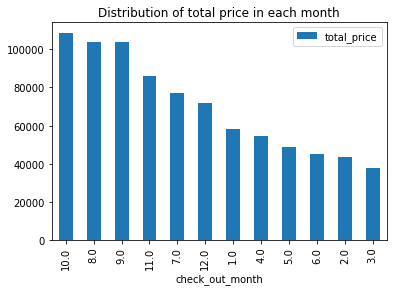

In [ ]:
df_month = df_date_price.groupby([df['check_out_month']]).sum().sort_values(['total_price'], ascending=False)
df_month.plot(kind='bar', title='Distribution of total price in each month')

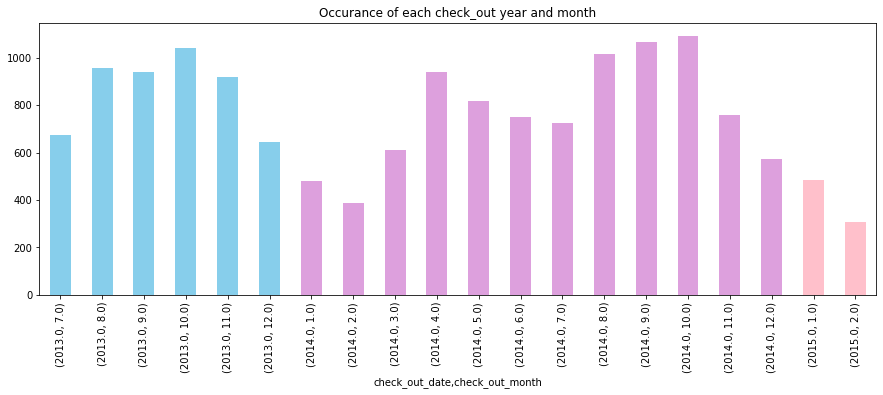

In [ ]:
o = 'skyblue'
t = 'plum'
h = 'mediumslateblue'
f = 'pink'
colors = [o, o, o, o, o, o, 
          t, t, t, t, t, t, t, t, t, t, t, t,
          f, f]

df_hist_date = df['check_out_date'].groupby([df['check_out_date'].dt.year, df['check_out_month']]).count()
df_hist_date.plot(kind='bar', figsize=(15,5), color=colors, 
                  title='Occurance of each check_out year and month')

Text(0.5, 1.0, 'Most number of days of staying')

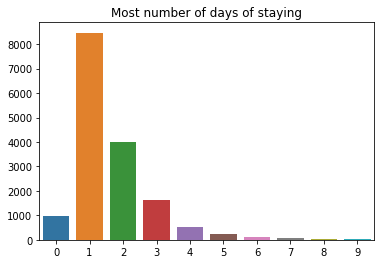

In [ ]:
df_stay = df['stay_duration'].value_counts().head(10)

sns.barplot(x=df_stay.index, y=df_stay.values).set_title('Most number of days of staying')

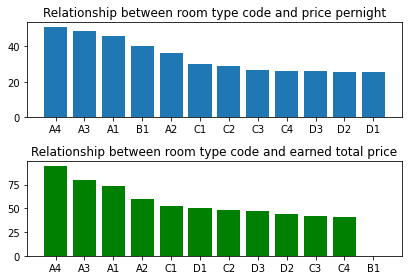

In [ ]:
df_code_price = df[['room_type_code', 'price_pernight', 'total_price']]
df_1 = df_code_price['price_pernight'].groupby([df['room_type_code']]).mean().sort_values(ascending=False)
df_2 = df_code_price['total_price'].groupby([df['room_type_code']]).mean().sort_values(ascending=False)


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

ax1.bar(df_1.index, df_1.values)
ax1.title.set_text('Relationship between room type code and price pernight')

ax2.bar(df_2.index, df_2.values, color='green')
ax2.title.set_text('Relationship between room type code and earned total price')

fig.tight_layout()
plt.show()

In [ ]:
df[df['room_type_code'] == 'B1']

,check_in_date,check_out_date,booking_date,Country,room_type_code,Status,stay_duration,price_pernight,check_in_month,check_out_month,book_month,check_in_day,check_out_day,book_day,check_in_weekday,check_out_weekday,book_weekday,book_date,book_time,total_price,book_check_diff,country_code
5721,NaT,NaT,2013-12-25 18:52:02+00:00,Unknown,B1,Cancelled,0,39.99,NaN,NaN,12,NaN,NaN,25,NaN,NaN,2,2013-12-25,18:52:02,0.0,NaT,Unknown


Text(0.5, 1.0, 'Contribution of each weekday in booking cancelation')

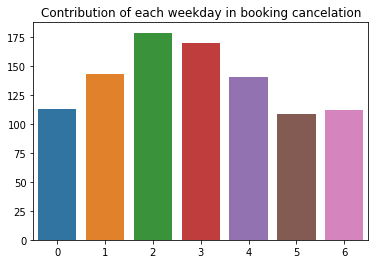

In [ ]:
df_week_cancel = df[df['Status'] == 'Cancelled']['book_weekday'].value_counts()
sns.barplot(x=df_week_cancel.index, 
            y=df_week_cancel.values).set_title('Contribution of each weekday in booking cancelation')

Text(0.5, 1.0, 'Contribution of each weekday in checking in hotel')

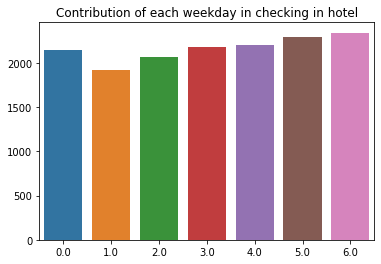

In [ ]:
df_week_check = df[df['Status'] == 'Checked Out']['check_in_weekday'].value_counts()
sns.barplot(x=df_week_check.index, 
            y=df_week_check.values).set_title('Contribution of each weekday in checking in hotel')

***
### World Map Visualization


In [ ]:
df_cnt = df[df['country_code'] != 'Unknown'][['country_code','total_price','Status']]
country_codes = df_cnt['country_code'].values

continents = []
alpha2 = []
alpha3 = []

for code in country_codes:
  continents.append(pyc.country_alpha2_to_continent_code(code))
  country_name = pyc.country_alpha2_to_country_name(code)
  alpha2.append(country_name)
  alpha3.append(pyc.country_name_to_country_alpha3(country_name))

df_cnt['Continent'] = continents
df_cnt['alpha2'] = alpha2
df_cnt['alpha3'] = alpha3
df_cnt['counts'] = [1] * df_cnt.shape[0]
df_cnt.head()

,country_code,total_price,Status,Continent,alpha2,alpha3,counts
0,NL,30.00,Checked Out,EU,Netherlands,NLD,1
1,DK,0.00,Cancelled,EU,Denmark,DNK,1
2,CH,50.76,Checked Out,EU,Switzerland,CHE,1
3,CH,59.20,Checked Out,EU,Switzerland,CHE,1
5,NL,48.38,Checked Out,EU,Netherlands,NLD,1


In [ ]:
ind = df_cnt['counts'].groupby(df_cnt['alpha3']).sum().index
val = df_cnt['counts'].groupby(df_cnt['alpha3']).sum().values

fig = px.choropleth(locations=ind,
                    color=val)

fig.update_layout(
    title_text = 'Contribution of eacy country in booking rooms'
)

fig.show()

In [ ]:
ind = df_cnt['total_price'].groupby(df_cnt['alpha3']).sum().index
val = df_cnt['total_price'].groupby(df_cnt['alpha3']).sum().values

fig = px.choropleth(locations=ind,
                    color=val)

fig.update_layout(
    title_text = 'Contribution of eacy country in paying total price'
)

fig.show()

In [ ]:
ind = df_cnt[df_cnt['Status'] == 'Cancelled']['counts'].groupby(df_cnt['alpha3']).sum().index
val = df_cnt[df_cnt['Status'] == 'Cancelled']['counts'].groupby(df_cnt['alpha3']).sum().values

fig = px.choropleth(locations=ind,
                    color=val)

fig.update_layout(
    title_text = 'Contribution of eacy country in cancelation of booking'
)

fig.show()

In [ ]:
ind = df_cnt['total_price'].groupby(df_cnt['Continent']).sum().index
val = df_cnt['total_price'].groupby(df_cnt['Continent']).sum().values 
fig = px.pie(values=val, 
             names=ind, 
             title='Contribution of each continent in paying total price')
fig.show()